# Syed Muhammad Zain Computer Vision Deep Learning Model


## Importing libraries

In [7]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import *
from keras.utils import np_utils
from keras.optimizers import Adam
from tqdm import tqdm
import seaborn as sns
import numpy as np
import numpy as np
import pandas as pd
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis

In [9]:
Train_data1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CV emnist project/EMNIST data set/emnist-balanced-train.csv', header=None)

In [10]:
Train_data1.shape

(112800, 785)

In [11]:
#splitting data into xtrain and ytrain
trainingy=Train_data1[[0]]
trainingx=Train_data1.drop([0],axis=1)
print(trainingy.shape)
print(trainingx.shape)

(112800, 1)
(112800, 784)


In [12]:
#converting to series
trainingy=Train_data1[0]
trainingy.shape

(112800,)

In [13]:
mapping=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CV emnist project/EMNIST data set/emnist-balanced-mapping.txt", 
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)
mapping.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [14]:
mappingdict = {}
for i,L in enumerate(mapping):
    mappingdict[i] = chr(L)

mappingdict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [15]:
def correctingimage(imageforcorrection):
    imageforcorrection = imageforcorrection.reshape(28, 28)
    imageforcorrection = np.fliplr(imageforcorrection)
    imageforcorrection = np.rot90(imageforcorrection)
    return imageforcorrection

In [16]:
trainingx = np.apply_along_axis(correctingimage, 1, trainingx)
trainingx.shape

(112800, 28, 28)

In [17]:
#normalizing x and one hot encoding y both are not dataframes
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) #-1 means number of examples are undefined/unknown
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [18]:
trainingx=preprocess(trainingx)

In [19]:
print(trainingx.max(),trainingx.min())

1.0 -1.0


In [20]:
gopt = Adam(0.0001, 0.5)
dopt = Adam(0.0002, 0.5)
ND = 100


## Training and testing

In [21]:
def Gena():

    convmodel = Sequential()

    convmodel.add(Dense(4096, input_dim=ND))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(Activation("relu"))
    
    convmodel.add(Dense(7350, input_dim=ND))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(Activation("relu"))
    
    convmodel.add(Reshape((7, 7, 150)))
    
    convmodel.add(UpSampling2D((2, 2)))
    convmodel.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(LeakyReLU(0.2))
    convmodel.add(UpSampling2D((2, 2)))
   
    convmodel.add(Conv2D(1, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return convmodel

In [22]:
def Disc():
    convmodel = Sequential()
    
    convmodel.add(Conv2D(64, (2, 2), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(28, 28, 1)))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Conv2D(128, (2, 2), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Flatten())
    
    
    convmodel.add(Dense(1024))
    convmodel.add(Dense(1024))
    convmodel.add(Dense(256))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Dropout(0.5))
    convmodel.add(Dense(1, activation='sigmoid'))
    
    convmodel.compile(loss='binary_crossentropy', optimizer=dopt)
    return convmodel

In [23]:
G = Gena()
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7350)              30112950  
_________________________________________________________________
batch_normalization_1 (Batch (None, 7350)              29400     
_________________________________________________________________
activation_1 (Activation)    (None, 7350)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 150)         0

In [24]:
D= Disc()
D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              6423552   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)             

In [25]:
noisegenerated = Input(shape=(ND,))
fake_data_generated = G(noisegenerated )
D.trainable = False
OUTPUT1 = D(fake_data_generated)
DCGAN=Model(noisegenerated , OUTPUT1)
DCGAN.compile(loss='binary_crossentropy', optimizer=gopt)
 





In [26]:
FN= np.random.normal(0, 1, size=(30, ND))


In [27]:
def show_results(title, epoch):
    imgs = G.predict(FN)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((28,28)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 15)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [28]:
epochs = 101
batch_size = 128
steps_per_epoch = len(trainingx)//batch_size

current epouch is:  0
discriminator loss currently is :  0.4303305149078369
generator loss currently is:  1.1822022199630737
--------------------------------------------------------------------------------


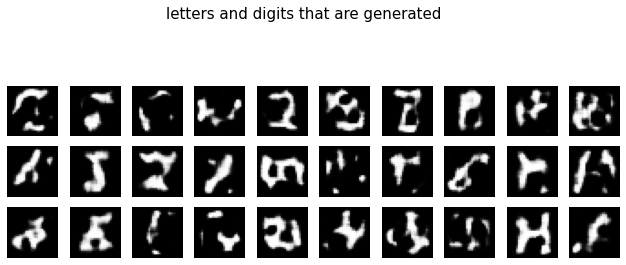

current epouch is:  1
discriminator loss currently is :  0.40063315629959106
generator loss currently is:  2.6364922523498535
--------------------------------------------------------------------------------
current epouch is:  2
discriminator loss currently is :  0.4222065806388855
generator loss currently is:  3.1102752685546875
--------------------------------------------------------------------------------
current epouch is:  3
discriminator loss currently is :  0.4475104808807373
generator loss currently is:  0.6647619605064392
--------------------------------------------------------------------------------
current epouch is:  4
discriminator loss currently is :  0.41588810086250305
generator loss currently is:  3.3894121646881104
--------------------------------------------------------------------------------
current epouch is:  5
discriminator loss currently is :  0.414354532957077
generator loss currently is:  0.6604005098342896
--------------------------------------------------

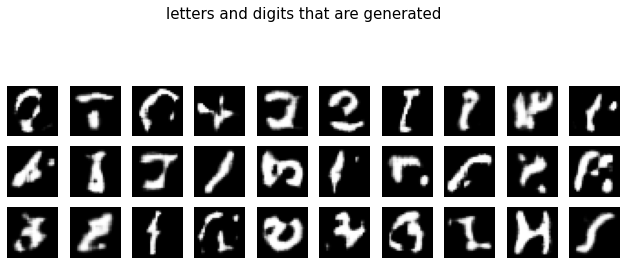

current epouch is:  6
discriminator loss currently is :  0.43943193554878235
generator loss currently is:  3.3222408294677734
--------------------------------------------------------------------------------
current epouch is:  7
discriminator loss currently is :  0.4232165217399597
generator loss currently is:  2.9032087326049805
--------------------------------------------------------------------------------
current epouch is:  8
discriminator loss currently is :  0.46176832914352417
generator loss currently is:  0.7915592789649963
--------------------------------------------------------------------------------
current epouch is:  9
discriminator loss currently is :  0.44350719451904297
generator loss currently is:  3.043867588043213
--------------------------------------------------------------------------------
current epouch is:  10
discriminator loss currently is :  0.4305759370326996
generator loss currently is:  2.8497138023376465
------------------------------------------------

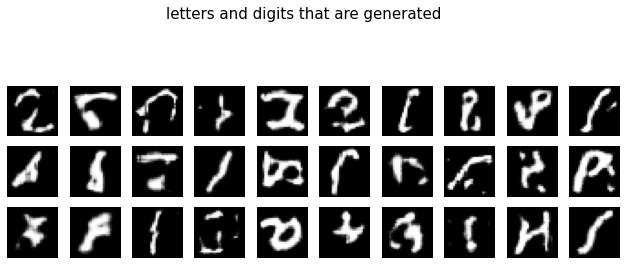

current epouch is:  11
discriminator loss currently is :  0.4135228097438812
generator loss currently is:  4.531463623046875
--------------------------------------------------------------------------------
current epouch is:  12
discriminator loss currently is :  0.40846577286720276
generator loss currently is:  7.082799434661865
--------------------------------------------------------------------------------
current epouch is:  13
discriminator loss currently is :  0.423927366733551
generator loss currently is:  4.956386566162109
--------------------------------------------------------------------------------
current epouch is:  14
discriminator loss currently is :  0.4129740595817566
generator loss currently is:  0.5033286213874817
--------------------------------------------------------------------------------
current epouch is:  15
discriminator loss currently is :  0.4295879900455475
generator loss currently is:  1.4423604011535645
-------------------------------------------------

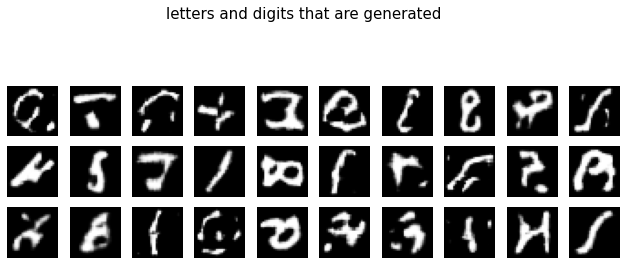

current epouch is:  16
discriminator loss currently is :  0.4249200224876404
generator loss currently is:  0.4526565670967102
--------------------------------------------------------------------------------
current epouch is:  17
discriminator loss currently is :  0.43048110604286194
generator loss currently is:  0.3494168817996979
--------------------------------------------------------------------------------
current epouch is:  18
discriminator loss currently is :  0.4236275851726532
generator loss currently is:  2.177818775177002
--------------------------------------------------------------------------------
current epouch is:  19
discriminator loss currently is :  0.4073065221309662
generator loss currently is:  4.545100688934326
--------------------------------------------------------------------------------
current epouch is:  20
discriminator loss currently is :  0.4222196936607361
generator loss currently is:  7.517642974853516
------------------------------------------------

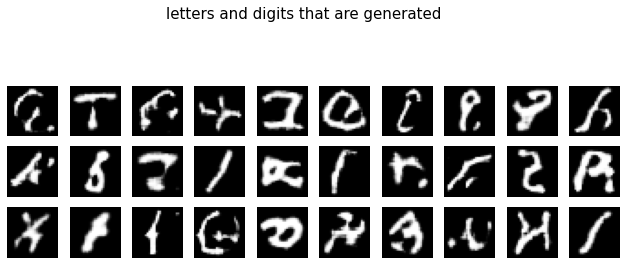

current epouch is:  21
discriminator loss currently is :  0.4136081337928772
generator loss currently is:  3.782750368118286
--------------------------------------------------------------------------------
current epouch is:  22
discriminator loss currently is :  0.41489893198013306
generator loss currently is:  3.9618911743164062
--------------------------------------------------------------------------------
current epouch is:  23
discriminator loss currently is :  0.39870500564575195
generator loss currently is:  0.6561391353607178
--------------------------------------------------------------------------------
current epouch is:  24
discriminator loss currently is :  0.4258764684200287
generator loss currently is:  4.534420490264893
--------------------------------------------------------------------------------
current epouch is:  25
discriminator loss currently is :  0.3998589813709259
generator loss currently is:  0.12189574539661407
---------------------------------------------

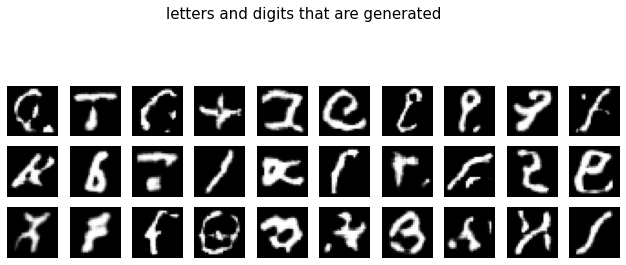

current epouch is:  26
discriminator loss currently is :  0.4069312810897827
generator loss currently is:  0.8971991539001465
--------------------------------------------------------------------------------
current epouch is:  27
discriminator loss currently is :  0.41606536507606506
generator loss currently is:  6.744753837585449
--------------------------------------------------------------------------------
current epouch is:  28
discriminator loss currently is :  0.3969317078590393
generator loss currently is:  4.658895492553711
--------------------------------------------------------------------------------
current epouch is:  29
discriminator loss currently is :  0.40577733516693115
generator loss currently is:  1.3185594081878662
--------------------------------------------------------------------------------
current epouch is:  30
discriminator loss currently is :  0.415596604347229
generator loss currently is:  1.4896210432052612
-----------------------------------------------

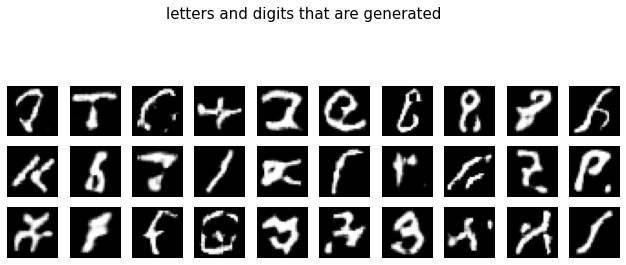

current epouch is:  31
discriminator loss currently is :  0.42333513498306274
generator loss currently is:  0.8730069994926453
--------------------------------------------------------------------------------
current epouch is:  32
discriminator loss currently is :  0.38586530089378357
generator loss currently is:  0.5727903842926025
--------------------------------------------------------------------------------
current epouch is:  33
discriminator loss currently is :  0.4501120448112488
generator loss currently is:  0.02521701343357563
--------------------------------------------------------------------------------
current epouch is:  34
discriminator loss currently is :  0.3886386454105377
generator loss currently is:  2.6483845710754395
--------------------------------------------------------------------------------
current epouch is:  35
discriminator loss currently is :  0.38499781489372253
generator loss currently is:  1.2182551622390747
------------------------------------------

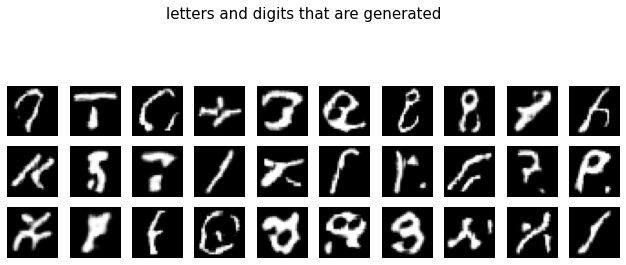

current epouch is:  36
discriminator loss currently is :  0.39604780077934265
generator loss currently is:  3.2198634147644043
--------------------------------------------------------------------------------
current epouch is:  37
discriminator loss currently is :  0.3961324691772461
generator loss currently is:  7.71146821975708
--------------------------------------------------------------------------------
current epouch is:  38
discriminator loss currently is :  0.38441628217697144
generator loss currently is:  7.199811935424805
--------------------------------------------------------------------------------
current epouch is:  39
discriminator loss currently is :  0.40836265683174133
generator loss currently is:  5.207907676696777
--------------------------------------------------------------------------------
current epouch is:  40
discriminator loss currently is :  0.39688077569007874
generator loss currently is:  1.3430308103561401
----------------------------------------------

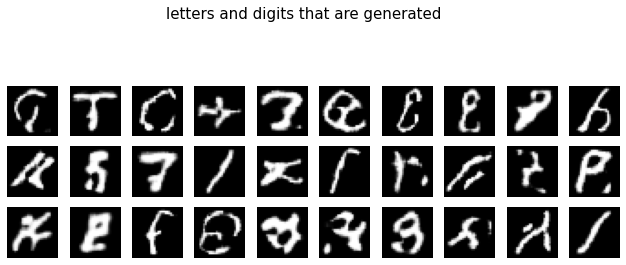

current epouch is:  41
discriminator loss currently is :  0.4053373336791992
generator loss currently is:  1.449244499206543
--------------------------------------------------------------------------------
current epouch is:  42
discriminator loss currently is :  0.3888552188873291
generator loss currently is:  0.33594924211502075
--------------------------------------------------------------------------------
current epouch is:  43
discriminator loss currently is :  0.4003450572490692
generator loss currently is:  0.14493218064308167
--------------------------------------------------------------------------------
current epouch is:  44
discriminator loss currently is :  0.38236647844314575
generator loss currently is:  1.586296558380127
--------------------------------------------------------------------------------
current epouch is:  45
discriminator loss currently is :  0.3798939883708954
generator loss currently is:  0.03297748789191246
--------------------------------------------

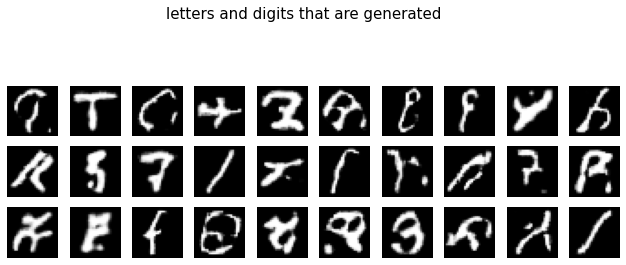

current epouch is:  46
discriminator loss currently is :  0.39283353090286255
generator loss currently is:  3.2678792476654053
--------------------------------------------------------------------------------
current epouch is:  47
discriminator loss currently is :  0.3792574107646942
generator loss currently is:  0.5484238862991333
--------------------------------------------------------------------------------
current epouch is:  48
discriminator loss currently is :  0.3953876793384552
generator loss currently is:  0.8845058679580688
--------------------------------------------------------------------------------
current epouch is:  49
discriminator loss currently is :  0.3827206790447235
generator loss currently is:  0.5248898267745972
--------------------------------------------------------------------------------
current epouch is:  50
discriminator loss currently is :  0.38271403312683105
generator loss currently is:  0.1437075436115265
--------------------------------------------

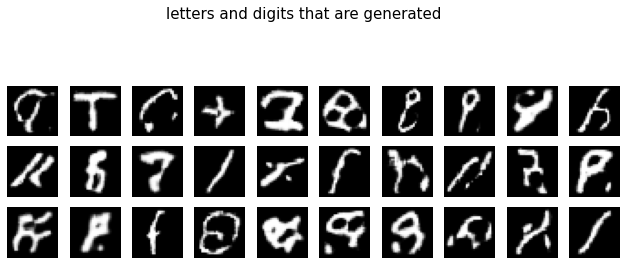

current epouch is:  51
discriminator loss currently is :  0.38167518377304077
generator loss currently is:  0.45091426372528076
--------------------------------------------------------------------------------
current epouch is:  52
discriminator loss currently is :  0.3763013184070587
generator loss currently is:  1.791294813156128
--------------------------------------------------------------------------------
current epouch is:  53
discriminator loss currently is :  0.393354594707489
generator loss currently is:  6.6420135498046875
--------------------------------------------------------------------------------
current epouch is:  54
discriminator loss currently is :  0.39499327540397644
generator loss currently is:  1.0669904947280884
--------------------------------------------------------------------------------
current epouch is:  55
discriminator loss currently is :  0.37516656517982483
generator loss currently is:  1.8914599418640137
--------------------------------------------

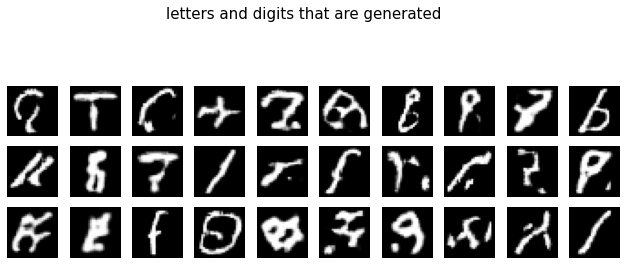

current epouch is:  56
discriminator loss currently is :  0.38343510031700134
generator loss currently is:  3.9202513694763184
--------------------------------------------------------------------------------
current epouch is:  57
discriminator loss currently is :  0.39046013355255127
generator loss currently is:  4.49329948425293
--------------------------------------------------------------------------------
current epouch is:  58
discriminator loss currently is :  0.3827407956123352
generator loss currently is:  7.390928268432617
--------------------------------------------------------------------------------
current epouch is:  59
discriminator loss currently is :  0.38474804162979126
generator loss currently is:  5.2338995933532715
--------------------------------------------------------------------------------
current epouch is:  60
discriminator loss currently is :  0.3953193128108978
generator loss currently is:  5.134312629699707
-----------------------------------------------

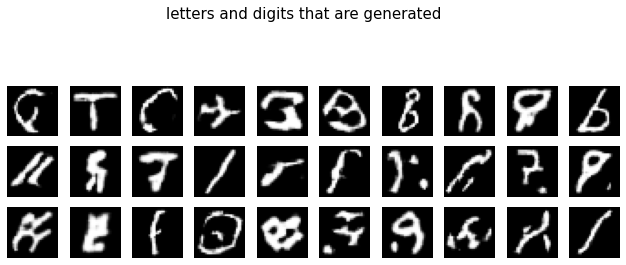

current epouch is:  61
discriminator loss currently is :  0.3779398798942566
generator loss currently is:  0.32121747732162476
--------------------------------------------------------------------------------
current epouch is:  62
discriminator loss currently is :  0.3861342668533325
generator loss currently is:  0.07846297323703766
--------------------------------------------------------------------------------
current epouch is:  63
discriminator loss currently is :  0.3714558482170105
generator loss currently is:  1.0624116659164429
--------------------------------------------------------------------------------
current epouch is:  64
discriminator loss currently is :  0.3993687927722931
generator loss currently is:  0.6522858142852783
--------------------------------------------------------------------------------
current epouch is:  65
discriminator loss currently is :  0.37879928946495056
generator loss currently is:  1.2817171812057495
-------------------------------------------

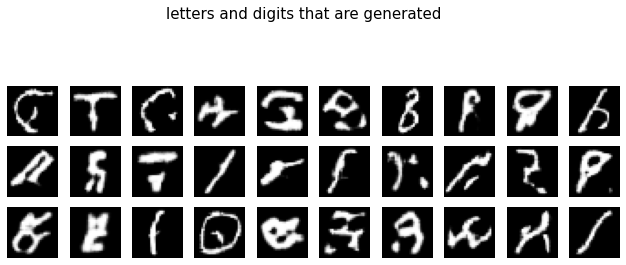

current epouch is:  66
discriminator loss currently is :  0.36506789922714233
generator loss currently is:  4.081174850463867
--------------------------------------------------------------------------------


In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        inputgenerator = np.random.normal(0, 1, size=(batch_size, ND))
        fakedataG = G.predict(inputgenerator)
        realdataG = trainingx[np.random.randint(0, trainingx.shape[0], size=batch_size)]
        realdataG = realdataG.reshape((batch_size, 28, 28, 1))
        inputdiscriminator= np.concatenate((realdataG , fakedataG))
        labeldiscriminator = np.zeros(2*batch_size)
        labeldiscriminator[:batch_size] = 0.9
        labeldiscriminator[batch_size:] = 0.1
        lossdiscriminator= D.train_on_batch(inputdiscriminator, labeldiscriminator)
        labelgenerator= np.ones(batch_size)
        lossgenerator = DCGAN.train_on_batch(inputgenerator, labelgenerator)

    print("current epouch is: ", epoch)
    print("discriminator loss currently is : ", lossdiscriminator)
    print("generator loss currently is: ", lossgenerator)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_results("letters and digits that are generated", epoch)